# Ripple-associated CG spectral analysis
https://github.com/Eden-Kramer-Lab/spectral_connectivity/blob/master/examples/Intro_tutorial.ipynb

<br>

### Imports

In [39]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from spectral_connectivity import Multitaper, Connectivity

warnings.filterwarnings('ignore')

<br>

### Define functions

In [222]:
def split_by_phase(df):
    
    sample_df = df.loc[df['phase']=='Sample'].drop(['phase'], axis=1)
    delay_df = df.loc[df['phase']=='Delay'].drop(['phase'], axis=1)
    test_df = df.loc[df['phase']=='Test'].drop(['phase'], axis=1)
    iti_df = df.loc[df['phase']=='ITI'].drop(['phase'], axis=1)
    
    return sample_df, delay_df, test_df, iti_df


def prepare_for_multitaper(df, n_tts):
    '''
    Rearrange and prepare data for multitaper.
    df, Dataframe. 
    n_tts, int - Number of tetrodes (may vary with dataset)
    '''
    
    # Normalise relative timestamp to correct small jitters
    #df['relative_timestamp']=df.relative_timestamp.round(8)

    # Drop unecessary columns
    to_drop = ['start_time', 'end_time','timestamp']#, 'relative_timestamp']
    df = df.drop(to_drop, axis=1)

    # Create TT list
    tts = ['TT{}'.format(x) for x in range(1,n_tts+1)]
    
    # Re-shape dataset into array    
    reshaped = df.pivot_table(
        index='i',#'relative_timestamp',#"bin_centres", 
        columns="ripple_nr", 
        values=tts,
        dropna=False
    ).values.reshape(
        (
        df['i'].nunique(),
        df['ripple_nr'].nunique(), # number of ripples
        n_tts
        )
    )
    
    return reshaped


def get_conn (df, fs, window, step, exp_type, nblocks, time_halfbandwidth_product):
    
    '''
    Prepares dataframe provided for multitaper
    Creates a multitaper object
    Inputs the multitaper object to create a connectivity object.
    '''
    
    multitaper = Multitaper(
        df, 
        sampling_frequency=fs, 
        n_time_samples_per_window = window,
        n_time_samples_per_step = step,
        time_halfbandwidth_product = time_halfbandwidth_product
    )
        
        
    conn = Connectivity.from_multitaper(
        multitaper, 
        expectation_type = exp_type, 
        blocks = nblocks
    )
    
    return conn   


def get_average_power(conn):
    
    '''
    Average power across tetrodes.
    conn, connectivty object. 
    '''  
    
    # Get time labels
    times = conn.time
    
    # Get frequencies
    freqs = conn.frequencies
    
    # Calculate power ((A,B,C,D) --> A) Time windows; B) trials; C) Frequencies; D) Tetrodes)
    power = conn.power()   
      
    # Average across tetrodes and SWRs
    # Resource: https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html
    averaged_power= np.nanmean(power, axis=(3,1))

    # Get standard deviations across tetrodes and SWRs
    std_power= power.std(axis=(3,1))
    
    return freqs, times, averaged_power, std_power, power

<br>

### Open datasets

In [223]:
main_path = 'PreProcessedData'
cg_data = pd.read_csv(os.path.join(main_path, 'cg_data.csv'), index_col=False)
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)

In [224]:
cg_data.loc[(cg_data['phase']=='Test (Pre-choice)')|(cg_data['phase']=='Test (Past-choice)'), 'phase']='Test'

In [199]:
# Calculate i, a cumulative count of rows per ripple
cg_data['i']=cg_data.groupby(['ripple_nr']).cumcount()

<br>

### Split dataset according to sampling rates & phase

In [28]:
# Currently the only session with 20K sampling
# ripple_data.loc[ripple_data.session_code == 20191113131818, 'ripple_nr'].unique() -- TO DROP AFTER REPROCESSING
#cg_data_2k = cg_data[cg_data.ripple_nr.between(0,74)]

In [103]:
cg_data = cg_data[~cg_data.ripple_nr.between(0,74)]  ## ---- TO DROP AFTER REPROCESSING

In [30]:
cg_data.groupby(['phase']).ripple_nr.nunique()

phase
Delay     114
ITI        98
Sample    186
Test      155
Name: ripple_nr, dtype: int64

In [31]:
# Split by phase
#sample_2k, delay_2k, test_2k, iti_2k = split_by_phase(cg_data_2k)
sample, delay, test, iti = split_by_phase(cg_data)

<br>

### Create connectivity object

In [12]:
## I NEED TO REPROCESS ALL 30Ks TO HAVE 20Ks - SO THAT ALL SAMPLES HAVE 5K / sec

#### 1. Prepare for multitaper
"If we have three dimensions, dimension 1 is time, dimension 2 is trials, and dimensions 3 is signals. It is important to know note that dimension 2 now has a different meaning in that it represents trials and not signals now. Dimension 3 is now the signals dimension. We will show an example of this later." time_series : array, shape (n_time_samples, n_trials, n_signals).

In [32]:
n_tts =14

In [48]:
reshaped_iti = prepare_for_multitaper(iti, n_tts= n_tts)
reshaped_sample = prepare_for_multitaper(sample, n_tts= n_tts)
reshaped_delay = prepare_for_multitaper(delay, n_tts= n_tts)
reshaped_test = prepare_for_multitaper(test, n_tts= n_tts)

<br>

#### 2.Create conn objects
##### 2.1 Create multitaper object

Controls the duration of the segment of time the transformation is computed on (seconds)
w_duration = 0.1
Control how far the time window is slid (overlap).
Setting the step to smaller than the time window duration will make the time windows overlap
step = 0.02
Controls the frequency resolution of the Fourier transformed signal.
Setting this parameter will define the default number of tapers used in the transform 
(number of tapers = 2 * time_halfbandwidth_product - 1.).
Need to study this one although setting the above automatically changes this one
time_halfbandwidth_product = 10

##### 2.2. Create connectivity object
The Connectivity class computes the frequency-domain connectivity measures from the Fourier coeffcients.

In [152]:
# janelas 100 ms
# com overlap de 1/10

fs = 3000
window = 150
step = 15
nblocks = 10
exp_type = "tapers"
time_halfbandwidth_product=1

In [153]:
iti_conn = get_conn(
    reshaped_iti,
    fs= fs, 
    window=window, 
    step=step, 
    time_halfbandwidth_product= time_halfbandwidth_product,
    exp_type=exp_type,
    nblocks=nblocks
)

#sample_conn = get_conn(
#    reshaped_sample,
#    fs= fs, 
#    window=window, 
#    step=step, 
#    time_halfbandwidth_product= time_halfbandwidth_product,
#    exp_type=exp_type,
#    nblocks=nblocks
#)

#delay_conn = get_conn(
#    reshaped_delay,
#    fs= fs, 
#    window=window, 
#    step=step, 
#    time_halfbandwidth_product= time_halfbandwidth_product,
#    exp_type=exp_type,
#    nblocks=nblocks
#)

#test_conn = get_conn(
#    reshaped_test,
#    fs= fs, 
#    window=window, 
#    step=step, 
#    time_halfbandwidth_product= time_halfbandwidth_product,
#    exp_type=exp_type,
#    nblocks=nblocks
#)

<br>


### Calculate aggregated power metrics for each SWR type

In [225]:
iti_freqs, iti_times, iti_mean_power, iti_std, iti_power= get_average_power(iti_conn)
# sample_freqs,sample_times, samplw_power, sample_std_power= get_average_power(sample_conn)
# delay_freqs, delay_times, delay_power, delay_std_power= get_average_power(delay_conn)
# test_freqs, test_times, test_power, test_std_power= get_average_power(test_conn)

In [232]:
iti_freqs.shape, iti_times.shape, iti_times.max()

((75,), (191,), 0.95)

<br>

### Power spectral density plot - Heatmap

Decibels scaling info [here](https://mark-kramer.github.io/Case-Studies-Python/03.html#step-5-decibel-scaling)

In [290]:
def create_psd(t, f, xx, decibel_scaling, title):
    
    '''
    Create the PSD plot for given dataset. 
    Returns fig object.
    t - array, times
    f - array, frequencies
    xx - array, power
    decibel_scaling - boolean, to perform decibel scaling on data
    title - the title of the plot
    '''
    
    # If decibel scaling is requested
    if decibel_scaling == True:
        xx =np.log10(xx/np.max(xx))
        
        
    fig, ax = plt.subplots(figsize=(6,3))
    ax.mesh = plt.pcolormesh(
        np.subtract(iti_times,.5),
        f,
        xx.squeeze().T,
        cmap="jet",
        shading="auto"
    )

    # Add vertical line
    plt.axvline(0, color='black', linestyle=':')
    
    
    # Define axes labels
    plt.ylabel('Frequencies (Hz)')
    plt.xlabel('Time to event (s)')
    
    # Define title
    plt.title(title)
      
    # Define axes limits
    plt.ylim((0,100))
    plt.xlim((-.5, .5))

    # Add color bar
    cb = fig.colorbar(
        ax.mesh,
        orientation="vertical",
        shrink=0.5,
        aspect=15,
        pad=0.1,
        label="Power (db)"
    )
    
    sns.despine()

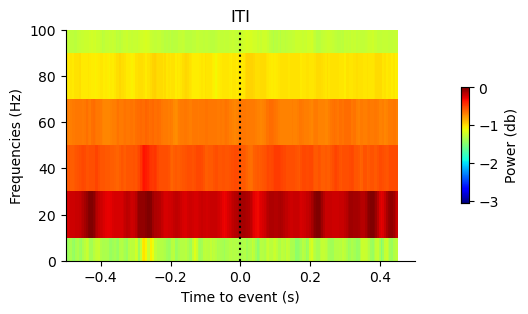

In [291]:
create_psd(iti_times, iti_freqs, iti_mean_power, decibel_scaling=True, title='ITI')
# plt.savefig(fname=, dpi=300, format='svg' )

In [81]:
# create_psd(sample_times, sample_freqs, sample_power, decibel_scaling=True, title='Sample')
# Save fig

In [82]:
# create_psd(delay_times, delay_freqs, delay_power, decibel_scaling=True, title='Delay')
# Save fig

In [83]:
# create_psd(test_times, test_freqs, test_power, decibel_scaling=True, title='Test')
# Save fig

<br>

### Power by bands

In [303]:
### Function to fetch data and create df

# Windows to analyse (~200ms)


# Re-calculate average across tetrodes (not trials)from power 
# essencially I will re-do average across trials in seaborn
averaged_iti_power= np.nanmean(iti_power, axis=(3)) #only across tetrodes

# Create boolean mask for windows
before_mask = (iti_times>=.3) & (iti_times <.5)
after_mask = (iti_times>.5) & (iti_times <=.7)

# Apply mask to power
before_power = averaged_iti_power[before_mask]
after_power = averaged_iti_power[before_mask]

#Create a dataframe with window as column (frequency x window)


#Apply seaborn

In [ ]:
#Apply seaborn